# A simple example with input noise where water-filling is not optimal

In [106]:
import numpy as np
from scipy.optimize import minimize

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Maximize information subject to output variance constraint

In [3]:
def info_single_channel(filter_amplitude, signal_std, input_noise_std, output_noise_std):
    return 0.5*np.log2(1 + ((filter_amplitude*signal_std)**2 / ((filter_amplitude*input_noise_std)**2 + output_noise_std**2)))

In [4]:
def output_var_single_channel(filter_amplitude, signal_std, input_noise_std, output_noise_std):
    return (filter_amplitude*signal_std)**2 + (filter_amplitude*input_noise_std)**2 + output_noise_std**2

### Total functions

In [10]:
def info_all_channels(filter_amplitudes, signal_stds, input_noise_stds, output_noise_stds):
    infos = [info_single_channel(filter_amplitudes[i], signal_stds[i], input_noise_stds[i], 
                                output_noise_stds[i]) for i in range(len(filter_amplitudes))]
    return np.sum(np.array(infos))

In [11]:
def output_var_all_channels(filter_amplitudes, signal_stds, input_noise_stds, output_noise_stds):
    variances = [output_var_single_channel(filter_amplitudes[i], signal_stds[i], input_noise_stds[i], 
                                output_noise_stds[i]) for i in range(len(filter_amplitudes))]
    return np.sum(np.array(variances))

## Toy problem

In [121]:
signal_stds = np.exp(-np.linspace(0,10,10))
input_noise_stds = [0.1]*len(signal_stds)
output_noise_stds = [0.4]*len(signal_stds)
target_var = 100.0

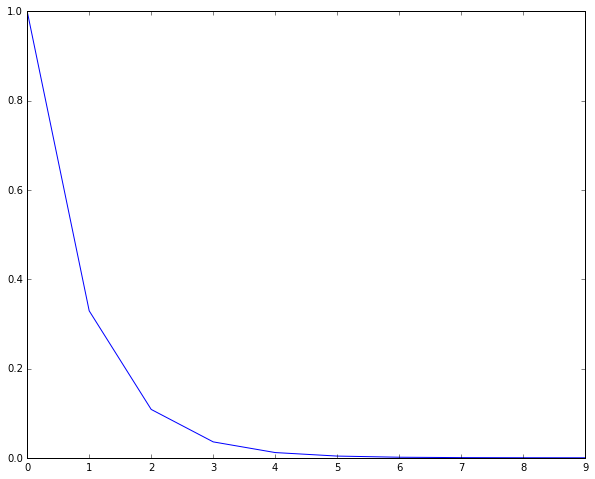

In [122]:
plt.plot(signal_stds)

In [123]:
info_all_channels([10., 1.], signal_stds, input_noise_stds, output_noise_stds)

3.5789145375819995

In [124]:
output_var_all_channels([10., 1.], signal_stds, input_noise_stds, output_noise_stds)

101.4383680232219

### Waterfilling solution where signal + noise is constant

In [125]:
def waterfilling_solution(signal_stds, input_noise_stds, output_noise_stds, power, constraint_strength=1.5):
    
    # return signal + noise for each channel
    def signal_and_noise(filter_amplitudes, signal_stds=signal_stds, input_noise_stds=input_noise_stds,
                        output_noise_stds=output_noise_stds):
        signals = np.array([(filter_amplitudes[i]*signal_stds[i])**2 for i in range(len(filter_amplitudes))])
        noise = np.array([(filter_amplitudes[i]*input_noise_stds[i])**2 + output_noise_stds[i] for i in range(len(filter_amplitudes))])
        return signals + noise
    
    def objective_fun(filter_amplitudes, signal_stds=signal_stds, input_noise_stds=input_noise_stds,
                        output_noise_stds=output_noise_stds, power=power, constraint_strength=constraint_strength):
        
        signals_and_noises = signal_and_noise(filter_amplitudes=filter_amplitudes, signal_stds=signal_stds, input_noise_stds=input_noise_stds,
                        output_noise_stds=output_noise_stds)
        differences = np.diff(signals_and_noises)
        
        
        return np.sum(differences**2) + constraint_strength*((power - np.sum(signals_and_noises))**2)
    
    x_opt = minimize(objective_fun, abs(np.random.randn(len(signal_stds))))
    x_opt['x'] = abs(x_opt['x'])
    
    return x_opt

In [126]:
x_opt = waterfilling_solution(signal_stds, input_noise_stds, output_noise_stds, target_var)

In [127]:
x_opt

      fun: 5.871269191803808e-14
 hess_inv: array([[  3.46322789e-02,   7.01114415e-02,   9.72773178e-02,
          5.34613164e-02,  -1.61964278e-02,  -8.12599382e-02,
         -1.30164708e-01,  -1.66836985e-01,  -1.91378264e-01,
         -2.04153202e-01],
       [  7.01114415e-02,   2.16377318e-01,   3.08230395e-01,
          1.93386013e-01,  -3.70920349e-03,  -1.97856889e-01,
         -3.39101480e-01,  -4.51063900e-01,  -5.29978379e-01,
         -5.79114109e-01],
       [  9.72773178e-02,   3.08230395e-01,   8.30716977e-01,
          6.09661245e-01,   1.48701601e-01,  -2.93909290e-01,
         -6.26453745e-01,  -8.82373506e-01,  -1.06709236e+00,
         -1.17044017e+00],
       [  5.34613164e-02,   1.93386013e-01,   6.09661245e-01,
          1.18953279e+00,   5.24403446e-01,  -8.82191430e-02,
         -5.07569062e-01,  -8.66674008e-01,  -1.12954026e+00,
         -1.26219000e+00],
       [ -1.61964278e-02,  -3.70920349e-03,   1.48701601e-01,
          5.24403446e-01,   1.09110236e+00

In [128]:
output_var_single_channel(x_opt['x'][0], signal_stds[0], input_noise_stds[0], output_noise_std[0])

9.7599997337084829

In [129]:
output_var_single_channel(x_opt['x'][1], signal_stds[1], input_noise_stds[1], output_noise_std[1])

9.7599996978335604

In [130]:
output_var_all_channels(x_opt['x'], signal_stds, input_noise_stds, output_noise_stds)

97.600000029256847

In [142]:
info_per_channel = [info_single_channel(x_opt['x'][i], signal_stds[i], input_noise_stds[i], output_noise_stds[i]) for i in range(len(x_opt['x']))]
print(info_per_channel)
print('%f bits' %sum(info_per_channel))

[2.6290159588756703, 1.6646467959234057, 0.54654106675651037, 0.084908948345527646, 0.0097172620753429931, 0.0010596002803932439, 0.00011490452280753557, 1.2452889786246443e-05, 1.3495057818957429e-06, 1.4624339991666214e-07]
4.936018 bits


## Now just maximize information, don't use waterfilling

In [149]:
def maximize_info_solution(signal_stds, input_noise_stds, output_noise_stds, power, constraint_strength=1.5):
    
    # return signal + noise for each channel
    def signal_and_noise(filter_amplitudes, signal_stds=signal_stds, input_noise_stds=input_noise_stds,
                        output_noise_stds=output_noise_stds):
        signals = np.array([(filter_amplitudes[i]*signal_stds[i])**2 for i in range(len(filter_amplitudes))])
        noise = np.array([(filter_amplitudes[i]*input_noise_stds[i])**2 + output_noise_stds[i] for i in range(len(filter_amplitudes))])
        return signals + noise
    
    def objective_fun(filter_amplitudes, signal_stds=signal_stds, input_noise_stds=input_noise_stds,
                        output_noise_stds=output_noise_stds, power=power, constraint_strength=constraint_strength):
        
        signals_and_noises = signal_and_noise(filter_amplitudes=filter_amplitudes, signal_stds=signal_stds, input_noise_stds=input_noise_stds,
                        output_noise_stds=output_noise_stds)
        
        total_info = info_all_channels(filter_amplitudes, signal_stds, input_noise_stds, output_noise_stds)
        
        return -total_info + constraint_strength*((power - np.sum(signals_and_noises))**2)
    
    x_opt = minimize(objective_fun, abs(np.random.randn(len(signal_stds))))
    x_opt['x'] = abs(x_opt['x'])
    
    return x_opt

In [150]:
x_opt_max = maximize_info_solution(signal_stds, input_noise_stds, output_noise_stds, target_var)
x_opt_max

      fun: -5.527154121487199
 hess_inv: array([[  1.54652330e+01,   5.52024079e+01,  -6.67108886e+01,
         -3.75230302e+01,   8.24915323e+00,  -4.74279916e+01,
          6.43641998e+00,  -1.49266687e+00,  -4.83791745e+00,
         -1.36115839e+01],
       [  5.52024079e+01,   3.35327220e+02,   9.41631765e+01,
          2.19403326e+02,   3.13660528e+02,   1.11625528e+02,
         -2.52037666e+00,  -3.90802483e+01,  -9.38014033e+01,
         -2.55197119e+02],
       [ -6.67108886e+01,   9.41631765e+01,   1.95600819e+03,
         -4.57198956e+02,  -4.59402472e+02,   3.75054241e+02,
         -5.73723859e+01,   1.15332684e+01,   3.88888369e+01,
          1.09710495e+02],
       [ -3.75230302e+01,   2.19403326e+02,  -4.57198956e+02,
          4.96313809e+03,   3.18171918e+02,   1.24490085e+01,
          3.40780499e+01,  -3.31991995e+01,  -8.67392311e+01,
         -2.38800576e+02],
       [  8.24915323e+00,   3.13660528e+02,  -4.59402472e+02,
          3.18171918e+02,   6.74659294e+03,  

In [151]:
output_var_single_channel(x_opt_max['x'][0], signal_stds[0], input_noise_stds[0], output_noise_std[0])

63.284716350472706

In [152]:
output_var_single_channel(x_opt_max['x'][1], signal_stds[1], input_noise_stds[1], output_noise_std[1])

22.473269653018008

In [153]:
output_var_all_channels(x_opt_max['x'], signal_stds, input_noise_stds, output_noise_stds)

97.600766490172418

In [154]:
info_per_channel_max = [info_single_channel(x_opt_max['x'][i], signal_stds[i], input_noise_stds[i], output_noise_stds[i]) for i in range(len(x_opt['x']))]
print(info_per_channel_max)
print('%f bits' %sum(info_per_channel))

[3.1665129095604838, 1.728991906796103, 0.54264358598699469, 0.080600363868038413, 0.0079634092897795591, 0.00044281909640051209, 7.6552289162316311e-09, 2.2120140519426006e-10, 1.5086024569898224e-10, 1.2288440170382445e-10]
4.936018 bits


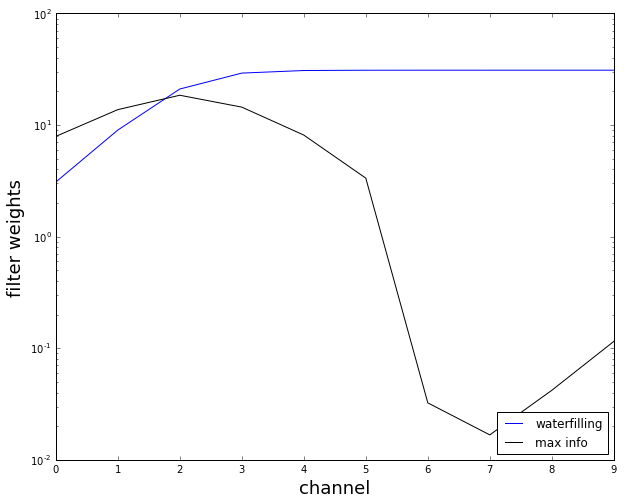

In [155]:
plt.plot(x_opt['x'], 'b', label='waterfilling')
plt.plot(x_opt_max['x'], 'k', label='max info')
plt.legend(loc='lower right')
plt.yscale('log')
plt.ylabel('filter weights', fontsize=18)
plt.xlabel('channel', fontsize=18)

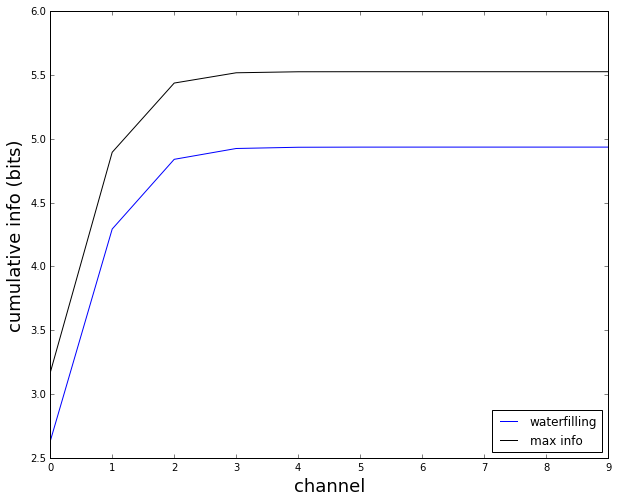

In [156]:
plt.plot(np.cumsum(info_per_channel), 'b', label='waterfilling')
plt.plot(np.cumsum(info_per_channel_max), 'k', label='max info')
plt.legend(loc='lower right')
plt.xlabel('channel', fontsize=18)
plt.ylabel('cumulative info (bits)', fontsize=18)

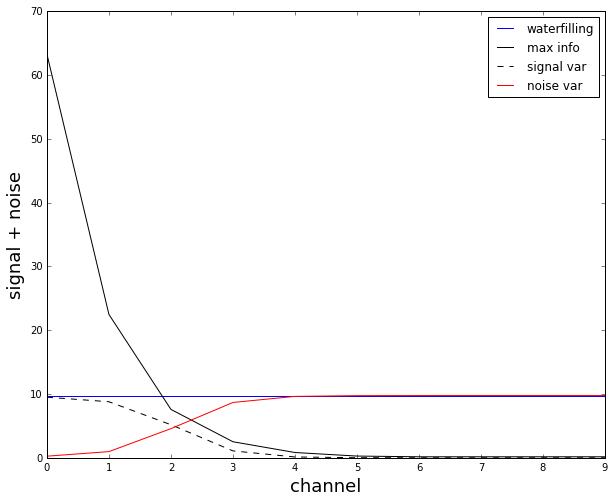

In [174]:
plt.plot([output_var_single_channel(x_opt['x'][i], signal_stds[i], input_noise_stds[i], output_noise_stds[i]) for i in range(len(x_opt_max['x']))], 'b', label='waterfilling')
plt.plot([output_var_single_channel(x_opt_max['x'][i], signal_stds[i], input_noise_stds[i], output_noise_stds[i]) for i in range(len(x_opt_max['x']))], 'k', label='max info')
plt.plot((signal_stds*x_opt['x'])**2, 'k--', label='signal var')
plt.plot(np.array(input_noise_stds*x_opt['x'])**2 + np.array(output_noise_stds)**2, 'r', label='noise var')
plt.legend()
plt.xlabel('channel', fontsize=18)
plt.ylabel('signal + noise', fontsize=18)